<a href="https://colab.research.google.com/github/pihk94/DeepLearning/blob/master/Cycle_GAN_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning : Generative Adversarial Networksand Cycle-GAN
### May 2020 / ENSAE 
###### Melchior Prugniaud

The purpose of this notebook is to reproduce the Cycle Gan presented [here](https://junyanz.github.io/CycleGAN/) which is an Image to Image translation and transform the MNIST dataset to the USPS. 

Following the [proposed assignment](http://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/assignments/assignment4.pdf), we will :

* Implement Deep Convolutionnal GAN

* Implement Cycle GAN

But first of all we need to import some packages and both dataset. I will use tensorflow and keras to do it.

In [1]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-dor7pmlm
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-dor7pmlm
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=0a5caca9df76a5aea9766539d1daf6778c1f82bbd4997797d2f704ca22cd3ace
  Stored in directory: /tmp/pip-ephem-wheel-cache-m6f_73j_/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
import tensorflow as tf
from tensorflow.keras.backend import resize_images
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
import numpy as np
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.utils.vis_utils import plot_model
from tensorflow.keras import layers
import os

# Prerequisite Datasets preprocessing

### Load MNIST Dataset
MNIST dataset consist of 70 000 digits of size 28x28.

In [0]:
train_mnist,test_mnist = mnist.load_data()
train_mnist[0].shape,train_mnist[1].shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,))

In [0]:
img_mnist,label_mnist = train_mnist[0],train_mnist[1]
imgs,labels = [],[]
j=0
while len(imgs)<=9:
  for i in range(len(img_mnist)):
    if not label_mnist[i] in labels and label_mnist[i] ==j:
      labels.append(label_mnist[i])
      imgs.append(img_mnist[i])
      j+=1

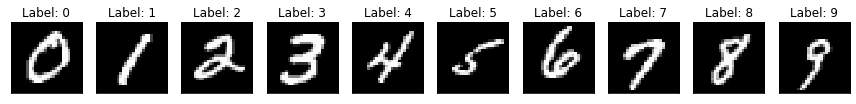

In [0]:
plt.figure(figsize =(12,12))
for i in range(1,11):
  plt.subplot(1,10,i)
  plt.imshow(imgs[i-1],cmap='gray',interpolation='none')
  plt.title("Label: {}".format(labels[i-1]))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()

Let's try to resize our image to 32 x 32 as asked in the input from the assignment.


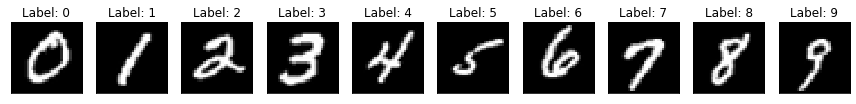

In [0]:
plt.figure(figsize =(12,12))
for i in range(1,11):
  plt.subplot(1,10,i)
  plt.imshow(cv2.resize(imgs[i-1], dsize=(32,32), interpolation=cv2.INTER_CUBIC),cmap='gray',interpolation='none')
  plt.title("Label: {}".format(labels[i-1]))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()

Looks like it's working good, we will apply it on a function to prepare datasets.
### Load USPS dataset

Let's now load the USPS dataset, unfortunately keras does not have the dataset, so we load it with torchvision.


In [0]:
from torchvision import datasets
train_usps = datasets.USPS(root='content/',download=True,train=True)
test_usps = datasets.USPS(root='content/',download=True,train=False)

In [0]:
train_usps[0]

(<PIL.Image.Image image mode=L size=16x16 at 0x7F025A020278>, 6)

In [0]:
data = train_usps
imgs,labels = [],[]
j=0
while len(imgs)<=9:
  for i in range(len(data)):
    if not data[i][1] in labels and data[i][1] ==j:
      labels.append(data[i][1])
      imgs.append(data[i][0])
      j+=1

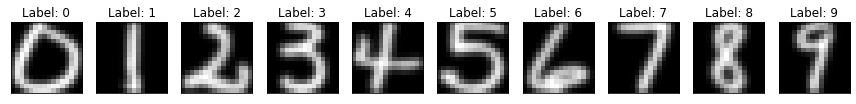

In [0]:
plt.figure(figsize =(12,12))
for i in range(1,11):
  plt.subplot(1,10,i)
  plt.imshow(imgs[i-1],cmap='gray',interpolation='none')
  plt.title("Label: {}".format(labels[i-1]))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()

Let's reshape again this 16x16 imgs to 32x32

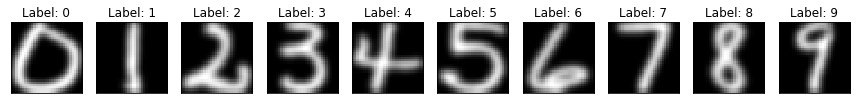

In [0]:
plt.figure(figsize =(12,12))
for i in range(1,11):
  plt.subplot(1,10,i)
  plt.imshow(imgs[i-1].resize((32,32)),cmap='gray',interpolation='none')
  plt.title("Label: {}".format(labels[i-1]))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()

## Prepare datasets loader

Here is two function , one for each dataset to load data in the good format for our networks.

# Part 1: Deep Convolutional GAN (DCGAN)

In the first part, the assignment ask to implement the DCGAN.
We will follow this blueprint : 

* Create discriminator

* Create generator

* Create the training procedure


## Discriminator

We have to reproduce this architecture : 


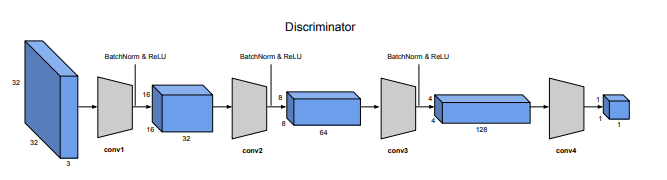

In [6]:
def dis_model(input_shape=(28,28,1)):
  init = RandomNormal(stddev=0.02) #as used in the article of CycleGan
  padding = 'same'
  kernels = (4,4)
  strides = (2,2)
  size = 64
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(32,(5,5),strides =strides,padding = padding,kernel_initializer=init,input_shape=input_shape))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.Conv2D(64,(5,5),strides =strides,padding = padding,kernel_initializer=init,input_shape=input_shape))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  return model
dis_model((28,28,1)).summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)             

Taking our initial shape, we got the following model for our discriminator.

## Generator

Let's now try to make the generator model. The representation is : 

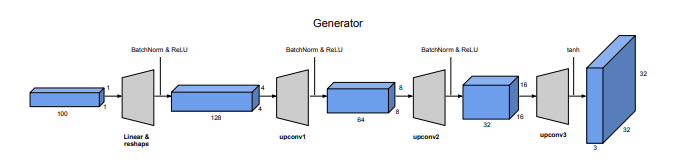

Since we have only 28x28 images, we delete one layer

In [7]:
def gen_model():
    init = RandomNormal(stddev=0.02) #as used in the article of CycleGan
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,),kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False,kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False,kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False,kernel_initializer=init,activation='tanh'))
    model.summary()
    return model
gen_model()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_9 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_10 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 7, 7, 128)        

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_12 (Batc (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_13 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 7, 7, 128)        

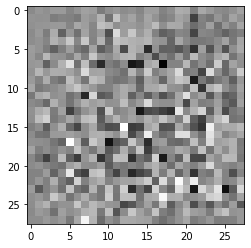

In [8]:
gen = gen_model()
noise = tf.random.normal([1, 100])
gen.training=False
generated_image = gen(noise)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

We then use the loss of our model

In [0]:
crossEntropy = BinaryCrossentropy(from_logits=True)
g_opti = Adam(lr=0.0002, beta_1=0.5)
d_opti = Adam(lr=0.0002, beta_1=0.5)

In [0]:
def d_loss(real,fake):
  true_loss = crossEntropy(tf.ones_like(real) , real)
  false_loss=  crossEntropy(tf.zeros_like(fake), fake)
  total = true_loss + false_loss
  return total
def g_loss(fake):
  return crossEntropy(tf.ones_like(fake), fake)

Set the seed

In [19]:
example = 25
seed = tf.random.normal([example,100])
gen =gen_model()
dis = dis_model()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_20 (Batc (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_21 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 7, 7, 128)        

Save results 

In [0]:
save_dir = "./Saves"
prefix = os.path.join(save_dir,"ckpt")
save = tf.train.Checkpoint(d_opti= d_opti,g_opti=g_opti,gen = gen,dis= dis)

In [0]:
@tf.function
def step(images,BATCH_SIZE=64,generator=gen,discriminator=dis):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generator.training=True
      generated_images = generator(noise)
      discriminator.training = True
      real_output = discriminator(images)
      discriminator.training = True
      fake_output = discriminator(generated_images)
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
def generate_and_save_images(model, epoch, test_input):
  model.training = False
  predictions = model(test_input)
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.savefig(f'image_at_epoch_{epoch}.png')
  plt.show()

In [0]:
def train(df, epochs = 50):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      step(image_batch)
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

Define the training step

In [13]:
@tf.function
def step(img,BATCH_SIZE=64):
  noise = tf.random.normal([BATCH_SIZE,100])
  with tf.GradientTape as gen_tape,tf.GradientTape() as disc_tape:
    

SyntaxError: ignored

## Training Loop


In [0]:
def load_mnist():
  (trainX,_),(_,_) = mnist.load_data()
  trainX = np.expand_dims(trainX, axis=-1)
  X = resize(trainX, (60000,32,32))
  return X
def real_samples(df,n_samples):
  ix = np.random.randint(0, df.shape[0], n_samples)
  X = df[ix]
  y = np.ones((n_samples,4,4,1))
  return X,y
def fake_samples(n_samples):
  X = np.random.rand(32*32*n_samples)
  X = X.reshape((n_samples,32,32,1))
  y = np.zeros((n_samples,4,4,1))
  return X,y
def train_discriminator(model, df, n_iter = 100,batch_size = 64,show_every=10):
  semi_batch = int(batch_size/2)
  for i in range(n_iter):
    X_real,y_real = real_samples(df,semi_batch)
    _, trueAcc = model.train_on_batch(X_real,y_real)
    X_fake,y_fake = fake_samples(semi_batch)
    _, fakeAcc = model.train_on_batch(X_fake,y_fake)
    if not i % show_every:
      print(f'Accuracy show for iter {i} :\nReal : {round(trueAcc*100,2)} Fake : {round(fakeAcc*100,2)}')

In [0]:
df = load_mnist()
model = discriminator((32,32,1))
train_discriminator(model,df,n_iter=200)

Accuracy show for iter 0 :
Real : 40.62 Fake : 32.03
Accuracy show for iter 10 :
Real : 75.39 Fake : 81.45
Accuracy show for iter 20 :
Real : 81.64 Fake : 79.49
Accuracy show for iter 30 :
Real : 98.05 Fake : 89.65
Accuracy show for iter 40 :
Real : 97.46 Fake : 92.19
Accuracy show for iter 50 :
Real : 99.8 Fake : 96.48
Accuracy show for iter 60 :
Real : 100.0 Fake : 97.27
Accuracy show for iter 70 :
Real : 99.8 Fake : 91.21
Accuracy show for iter 80 :
Real : 98.63 Fake : 99.8
Accuracy show for iter 90 :
Real : 98.83 Fake : 99.61
Accuracy show for iter 100 :
Real : 100.0 Fake : 100.0
Accuracy show for iter 110 :
Real : 99.61 Fake : 100.0
Accuracy show for iter 120 :
Real : 99.8 Fake : 99.61
Accuracy show for iter 130 :
Real : 100.0 Fake : 100.0
Accuracy show for iter 140 :
Real : 99.22 Fake : 100.0
Accuracy show for iter 150 :
Real : 100.0 Fake : 100.0
Accuracy show for iter 160 :
Real : 99.8 Fake : 100.0
Accuracy show for iter 170 :
Real : 99.8 Fake : 100.0
Accuracy show for iter 180 

In [0]:
def generator_fake_samples(model,n_samples):
  x_input = np.random.randn(32*32*n_samples)
  x_input = x_input.reshape((n_samples,32,32,1))
  X = model.predict(x_input)
  y = np.zeros((n_samples,4,4,1))
  return X,y

In [0]:
model = generator((32,32,1))

In [0]:
X,_ = generator_fake_samples(model,25)

Here is a representation of the untrained generator.

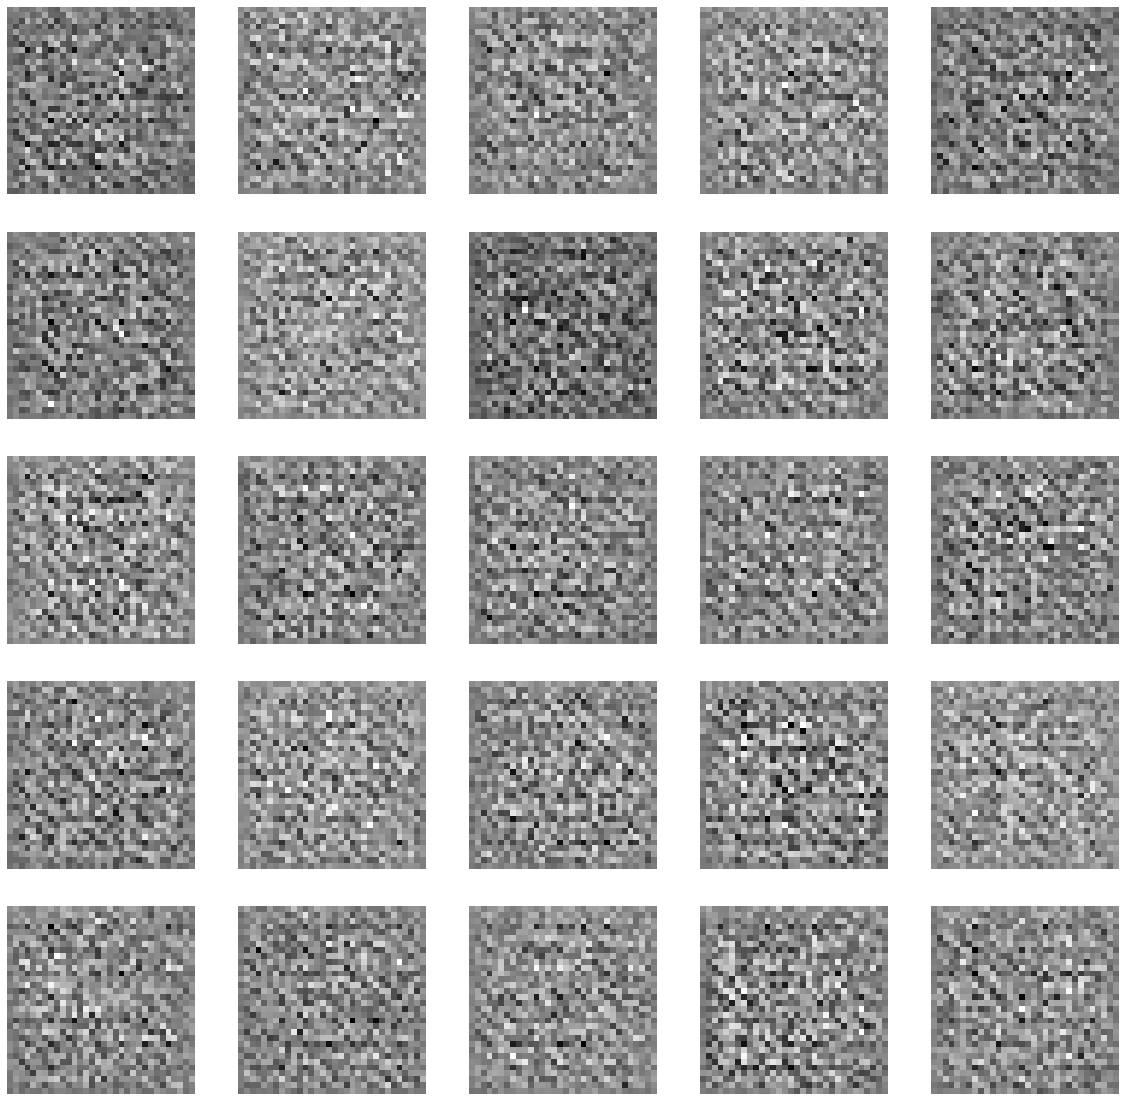

In [0]:
plt.figure(figsize=(20,20))
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(X[i, :, :, 0], cmap='gray_r')

Let's now train the generator model.

The generators weights are updated with the discriminator performance. Indeed, when the discriminator is performing well at detecting fake samples then the generator receive more update. A contrario, when the disciminator is performing poorly to detect fake samples, the generator is updated less.

This is the adversarial relationship between the discriminator and the generator.

We will now create a simple approch to combine both models to a pseudo new model.

In [0]:
def GAN()